# Build and Fine-tune a LightGBM model

In [2]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

# Detect project root (parent of notebooks/)
ROOT = Path.cwd().parents[0]

# Add root to path if not present
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Define paths used in the pipeline
DATA_TRAIN   = ROOT / "data" / "interim" / "training_fe.csv"
DATA_LABELS  = ROOT / "data" / "raw" / "training_set_labels.csv"
DATA_TEST    = ROOT / "data" / "interim" / "test_fe.csv"
ARTIFACTS    = ROOT / "artifacts"

In [3]:
# Train Baseline Models
from src.modeling import train_baseline_models

print("Training baseline models...")
baseline_results = train_baseline_models(
    train_features=str(DATA_TRAIN),
    train_labels=str(DATA_LABELS),
    outdir=str(ARTIFACTS)
)

print("\n=== Baseline Results ===")
for target, metrics in baseline_results.items():
    print(f"\n{target}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Training baseline models...

=== Baseline Results ===

h1n1_vaccine:
  accuracy: 0.8512
  precision: 0.7058
  recall: 0.5137
  f1: 0.5946
  roc_auc: 0.8609

seasonal_vaccine:
  accuracy: 0.7907
  precision: 0.7845
  recall: 0.7671
  f1: 0.7757
  roc_auc: 0.8634


In [5]:
# Load Training Data for Fine-Tuning
from src.modeling import load_training_data, TARGET_COLS

print("Loading training data...")
X, y = load_training_data(str(DATA_TRAIN), str(DATA_LABELS))

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
print(f"Targets: {TARGET_COLS}")

Loading training data...
Loaded 26707 samples with 72 features
Targets: ['h1n1_vaccine', 'seasonal_vaccine']


In [6]:
# Fine-Tune H1N1 Model
from src.modeling import tune_model

print("Fine-tuning h1n1_vaccine model...")
h1n1_params, h1n1_metrics = tune_model(
    X, 
    y["h1n1_vaccine"], 
    "h1n1_vaccine", 
    outdir=str(ARTIFACTS)
)

print("\n=== H1N1 Tuned Model ===")
print("Best Parameters:", h1n1_params)
print("\nMetrics:")
for metric, value in h1n1_metrics.items():
    print(f"  {metric}: {value:.4f}")

Fine-tuning h1n1_vaccine model...

=== H1N1 Tuned Model ===
Best Parameters: {'bagging_fraction': np.float64(0.7380284992106732), 'bagging_freq': 1, 'feature_fraction': np.float64(0.695824756266789), 'lambda_l1': np.float64(0.1448948720912231), 'lambda_l2': np.float64(0.489452760277563), 'max_depth': 8, 'min_child_samples': 41, 'num_leaves': 74}

Metrics:
  accuracy: 0.8261
  precision: 0.5728
  recall: 0.7000
  f1: 0.6300
  roc_auc: 0.8650
  cv_f1_score: 0.6307


In [7]:
# Fine-Tune Seasonal Flu Model
print("Fine-tuning seasonal_vaccine model...")
seasonal_params, seasonal_metrics = tune_model(
    X, 
    y["seasonal_vaccine"], 
    "seasonal_vaccine", 
    outdir=str(ARTIFACTS)
)

print("\n=== Seasonal Vaccine Tuned Model ===")
print("Best Parameters:", seasonal_params)
print("\nMetrics:")
for metric, value in seasonal_metrics.items():
    print(f"  {metric}: {value:.4f}")

Fine-tuning seasonal_vaccine model...

=== Seasonal Vaccine Tuned Model ===
Best Parameters: {'bagging_fraction': np.float64(0.9627313766183017), 'bagging_freq': 1, 'feature_fraction': np.float64(0.6911740650167767), 'lambda_l1': np.float64(0.4271077886262563), 'lambda_l2': np.float64(0.8180147659224931), 'max_depth': 11, 'min_child_samples': 12, 'num_leaves': 58}

Metrics:
  accuracy: 0.7937
  precision: 0.7809
  recall: 0.7650
  f1: 0.7729
  roc_auc: 0.8657
  cv_f1_score: 0.7690


In [9]:
# Store Tuning Results
tuned_params = {
    "h1n1_vaccine": h1n1_params,
    "seasonal_vaccine": seasonal_params
}

tuned_metrics = {
    "h1n1_vaccine": h1n1_metrics,
    "seasonal_vaccine": seasonal_metrics
}

print("Tuning completed for both targets")

Tuning completed for both targets


In [10]:
# Train Final H1N1 Model on Full Dataset
from src.modeling import train_final_model

print("Training final h1n1_vaccine model on full dataset...")
final_h1n1 = train_final_model(
    X, 
    y["h1n1_vaccine"], 
    "h1n1_vaccine", 
    tuned_params["h1n1_vaccine"],
    outdir=str(ARTIFACTS)
)

Training final h1n1_vaccine model on full dataset...
✓ Final model for h1n1_vaccine saved


In [11]:
# Train Final Seasonal Flu Model on Full Dataset
print("Training final seasonal_vaccine model on full dataset...")
final_seasonal = train_final_model(
    X, 
    y["seasonal_vaccine"], 
    "seasonal_vaccine", 
    tuned_params["seasonal_vaccine"],
    outdir=str(ARTIFACTS)
)

Training final seasonal_vaccine model on full dataset...
✓ Final model for seasonal_vaccine saved


In [12]:
# Load Final Models for Prediction
from src.modeling import load_final_models

print("Loading final models for prediction...")
final_models = load_final_models(str(ARTIFACTS))

print(f"Loaded {len(final_models)} final models")
for target in TARGET_COLS:
    print(f"  - {target}")

Loading final models for prediction...
Loaded 2 final models
  - h1n1_vaccine
  - seasonal_vaccine


In [13]:
# Generate Test Predictions
from src.modeling import predict_test

print("Generating test predictions...")
df_submit = predict_test(final_models, str(DATA_TEST))

print(f"✓ Generated predictions for {len(df_submit)} test samples")
print("\nSubmission Preview:")
print(df_submit.head(10))

Generating test predictions...
✓ Generated predictions for 26708 test samples

Submission Preview:
   respondent_id  h1n1_vaccine  seasonal_vaccine
0          26707      0.097353          0.225712
1          26708      0.052727          0.025124
2          26709      0.155714          0.704950
3          26710      0.788193          0.887429
4          26711      0.251074          0.558814
5          26712      0.849638          0.977174
6          26713      0.290720          0.661916
7          26714      0.136260          0.114415
8          26715      0.015857          0.072627
9          26716      0.289856          0.914841


In [14]:
# Save Submission File
submission_path = ROOT / "submission.csv"
df_submit.to_csv(submission_path, index=False)

print(f"✓ Submission saved to: {submission_path}")
print(f"  Shape: {df_submit.shape}")
print(f"  Columns: {list(df_submit.columns)}")

✓ Submission saved to: c:\Projects\Flushot\submission.csv
  Shape: (26708, 3)
  Columns: ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']


In [15]:
# Summary Statistics
print("\n=== SUBMISSION SUMMARY ===")
print(f"\nTotal predictions: {len(df_submit)}")
print("\nH1N1 Vaccine Probabilities:")
print(df_submit["h1n1_vaccine"].describe())
print("\nSeasonal Vaccine Probabilities:")
print(df_submit["seasonal_vaccine"].describe())


=== SUBMISSION SUMMARY ===

Total predictions: 26708

H1N1 Vaccine Probabilities:
count    26708.000000
mean         0.204345
std          0.254742
min          0.000693
25%          0.030611
50%          0.083096
75%          0.274142
max          0.987862
Name: h1n1_vaccine, dtype: float64

Seasonal Vaccine Probabilities:
count    26708.000000
mean         0.464667
std          0.322650
min          0.005529
25%          0.149773
50%          0.425790
75%          0.787649
max          0.991881
Name: seasonal_vaccine, dtype: float64


In [16]:
# Compare Baseline vs Tuned Performance
import json

print("\n=== PERFORMANCE COMPARISON ===")

for target in TARGET_COLS:
    print(f"\n{target.upper().replace('_', ' ')}:")
    print("-" * 50)
    
    # Load baseline metrics
    with open(ARTIFACTS / f"baseline_{target}_metrics.json") as f:
        baseline = json.load(f)
    
    # Load tuned metrics
    with open(ARTIFACTS / f"tuned_{target}_metrics.json") as f:
        tuned = json.load(f)
    
    print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
    print("-" * 50)
    
    for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        base_val = baseline[metric]
        tune_val = tuned[metric]
        change = tune_val - base_val
        change_pct = (change / base_val * 100) if base_val > 0 else 0
        
        print(f"{metric:<15} {base_val:<12.4f} {tune_val:<12.4f} {change:+.4f} ({change_pct:+.2f}%)")


=== PERFORMANCE COMPARISON ===

H1N1 VACCINE:
--------------------------------------------------
Metric          Baseline     Tuned        Change      
--------------------------------------------------
accuracy        0.8512       0.8261       -0.0251 (-2.95%)
precision       0.7058       0.5728       -0.1330 (-18.85%)
recall          0.5137       0.7000       +0.1863 (+36.28%)
f1              0.5946       0.6300       +0.0354 (+5.96%)
roc_auc         0.8609       0.8650       +0.0042 (+0.48%)

SEASONAL VACCINE:
--------------------------------------------------
Metric          Baseline     Tuned        Change      
--------------------------------------------------
accuracy        0.7907       0.7937       +0.0030 (+0.38%)
precision       0.7845       0.7809       -0.0036 (-0.46%)
recall          0.7671       0.7650       -0.0021 (-0.27%)
f1              0.7757       0.7729       -0.0028 (-0.36%)
roc_auc         0.8634       0.8657       +0.0023 (+0.27%)


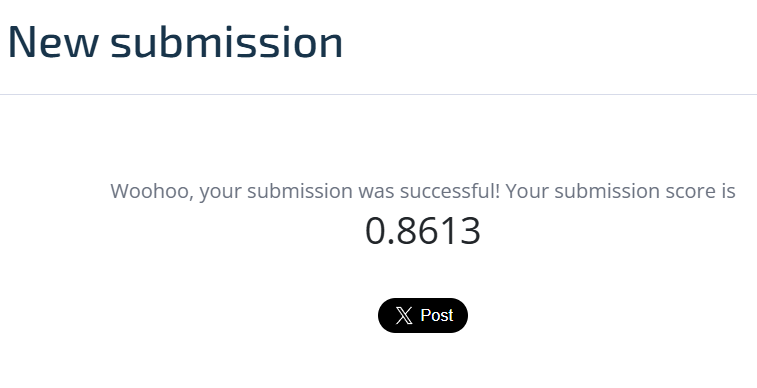

In [18]:
from IPython.display import Image
Image("../Submission_best.png")